In [1]:
"""
@author: Mark Bugden, Max Planck Institute for Animal Behavior. 
November 2022


Most recent update available on github:
"""




# Import numpy and tensorflow
import numpy as np
import tensorflow as tf

print('tf version: ', tf. __version__)

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)


# Import matplotlib, pandas, and scipy
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import seaborn as sns
from scipy import stats
from tensorflow import keras


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


# Set the location of the folder in which the data is stored 
data_folder_location = "D:\\Data\\TRex data\\"

tf version:  2.10.0


In [2]:
# Check to see if tensorflow is running on CPU or GPU

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10781256192651069545
xla_global_id: -1
]


In [3]:
# How many GPUs are available?

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
# Load and preview the dataframe containing the Fish numbers, frame numbers, times, positions, velocities, speeds, and densities.
raw_dataset = pd.read_csv(data_folder_location+"1024sunbleak_clean.csv", index_col=0)
df = raw_dataset.copy()
df = df.rename(columns={'vx':'u', 'vy':'v'})

df.head()

,t,x,y,frame,u,v,speed,density
Fish,,,,,,,,
0,0.224779,72.01117,119.371750,8,0.187607,-0.008820,0.187814,0.000083
0,0.249735,72.19878,119.362930,9,0.187607,-0.008812,0.187814,0.000083
0,0.274696,72.38638,119.354120,10,0.225456,-0.018173,0.226187,0.000083
0,0.299712,72.61184,119.335945,11,0.240097,-0.060448,0.247589,0.000083
0,0.324633,72.85194,119.275500,12,0.185051,-0.079430,0.201378,0.000083


In [6]:
# Check that none of the data is NaN
df.isna().sum()

t          0
x          0
y          0
frame      0
u          0
v          0
speed      0
density    0
dtype: int64

In [7]:
# Rescale the density and velocity columns column to be between 0 and 1
df["density"] = (df["density"] - df["density"].min())/(df["density"].max() - df["density"].min())
df["u"] = (df["u"] - df["u"].min())/(df["u"].max() - df["u"].min())
df["v"] = (df["v"] - df["v"].min())/(df["v"].max() - df["v"].min())

In [8]:
# Create a dictionary frametotime, whose keys are frame numbers and whose values are the associated time.
frametotime = dict(zip(df.frame, df.t))
    

In [9]:
# Get the upper and lower bounds for all our input data
xmin = df['x'].min()
xmax = df['x'].max()
ymin = df['y'].min()
ymax = df['y'].max()
tmin = df['t'].min()
tmax = df['t'].max()

# Store the bounds in a constant array
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

In [10]:
# Choose a random selection of frames from our data to feed into the neural network
N_train = 1000
N_test = 100

# Set a random seed so that our results are reproducable
np.random.seed(1335)

# Choose a random set of frames, the first N_train of which will be used for training, and the remaining to be used for testing
idx = np.random.choice(df["frame"].max(), N_train+N_test, replace=False)
idx_train = list(idx[0:N_train]) 
idx_test = list(idx[N_train:])

train_data = df.query(f"frame.isin({idx_train})")
test_data = df.query(f"frame.isin({idx_test})")

In [11]:
# Split features from labels. The features (inputs to the neural network) are the positions in space and time, and the labels (outputs) are the u and v components of velocity,
# together with the density. 

train_features = train_data[['t', 'x', 'y']].copy()
test_features = test_data[['t', 'x', 'y']].copy()

train_labels = train_data[['u', 'v', 'density']].copy()
test_labels = test_data[['u','v', 'density']].copy()

In [12]:
# Format the data into Tensorflow language


t_train_data = tf.reshape(tf.convert_to_tensor(train_features['t'], dtype=DTYPE), (-1,1) )
x_train_data = tf.reshape(tf.convert_to_tensor(train_features['x'], dtype=DTYPE), (-1,1))
y_train_data = tf.reshape(tf.convert_to_tensor(train_features['y'], dtype=DTYPE), (-1,1))

u_train_data = tf.reshape(tf.convert_to_tensor(train_labels['u'], dtype=DTYPE), (-1,1))
v_train_data = tf.reshape(tf.convert_to_tensor(train_labels['v'], dtype=DTYPE), (-1,1))
density_train_data = tf.reshape(tf.convert_to_tensor(train_labels['density'], dtype=DTYPE), (-1,1))

# Concatenate the training data
X_train_data = tf.concat([t_train_data, x_train_data, y_train_data], axis=1)
U_train_data = tf.concat([u_train_data, v_train_data, density_train_data], axis=1)



t_test_data = tf.reshape(tf.convert_to_tensor(test_features['t'], dtype=DTYPE), (-1,1) )
x_test_data = tf.reshape(tf.convert_to_tensor(test_features['x'], dtype=DTYPE), (-1,1))
y_test_data = tf.reshape(tf.convert_to_tensor(test_features['y'], dtype=DTYPE), (-1,1))

u_test_data = tf.reshape(tf.convert_to_tensor(test_labels['u'], dtype=DTYPE), (-1,1))
v_test_data = tf.reshape(tf.convert_to_tensor(test_labels['v'], dtype=DTYPE), (-1,1))
density_test_data = tf.reshape(tf.convert_to_tensor(test_labels['density'], dtype=DTYPE), (-1,1))

# Concatenate the testing data
X_test_data = tf.concat([t_test_data, x_test_data, y_test_data], axis=1)
U_test_data = tf.concat([u_test_data, v_test_data, density_test_data], axis=1)
print(X_train_data.shape)
print(X_test_data.shape)

print(U_train_data.shape)
print(U_test_data.shape)

(1087457, 3)
(108968, 3)
(1087457, 3)
(108968, 3)


In [13]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network, with frozen layers
    

    model = tf.keras.Sequential()


    # Some useful variables
    model.num_hidden_layers = num_hidden_layers
    model.num_neurons_per_layer = num_neurons_per_layer
    
    
    # Input is three-dimensional (time + two spatial dimensions)
    model.add(tf.keras.Input(3))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0, name='Scale')
    scaling_layer.trainable = False
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        layer = tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='HeNormal', name='HiddenLayer'+str(_+1))
        layer.trainable=False
        model.add(layer)

    # Output is three-dimensional
    output_layer = tf.keras.layers.Dense(3, name='Output')
    output_layer.trainable = False
    model.add(output_layer)
    
    
    # Initialize variables for lambda. These are trainable parameters to be used in the loss function later.
    model.lambd1 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda1')
    model.lambd2 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda2')
    model.lambd3 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda3')
    model.lambd4 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda4')
    model.lambd5 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda5')
    model.lambd6 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda6')
    model.lambd7 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda7')
    model.lambd8 = tf.Variable(1.0, trainable=True, dtype=DTYPE, name='lambda8')
    

    
    return model

In [14]:
# Create a function which displays the prediction and the data side by side for densities

def compare_densities3D(fr, model):
    ''' Graphs the densities of the fish at frame fr and displays it next to the data so that it can be compared.
    
    '''
    
    plotdf = df[df["frame"] == fr] 
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(plotdf['x'], plotdf['y'], plotdf['density'], c=plotdf['density'])
    ax.set_zlim3d(0,5)
    ax.title.set_text('Actual density')
    
        
    t = frametotime[fr]

    xspace = np.linspace(lb[1], ub[1],51)
    yspace = np.linspace(lb[2], ub[2],51)
    tuples = tf.constant([[t, x, y] for x in xspace for y in yspace])
    densities = model(tuples)


    xs = [tuple[1:2] for tuple in tuples]
    ys = [tuple[2:] for tuple in tuples]
    pltdensity = [point[2] for point in densities]

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_zlim3d(0,5)

    ax.scatter(xs, ys, pltdensity, c=pltdensity)
    
    ax.title.set_text('Predicted density')
    
    fig.set_size_inches(12, 6)
    
    return fig
    

In [15]:



def compare_densities2D(fr, model, BW=None):
    ''' Graphs the densities of the fish at frame fr and displays it next to the data so that it can be compared.
    
    '''
    
    
    datax = np.array(df.query(f'frame == {fr}')['x'])
    datay = np.array(df.query(f'frame == {fr}')['y'])
    values = np.vstack((datax, datay))
    
    kernel = stats.gaussian_kde(values, bw_method=BW)
    
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)

    fig, ax = plt.subplots()
    
    ax = fig.add_subplot(1, 2, 1)
    
    ax.imshow(np.rot90(Z))
    
    ax.title.set_text('Actual density')

        
    plt.axis('off')
        
    t = frametotime[fr]

    xspace = np.linspace(lb[1], ub[1],101)
    yspace = np.linspace(lb[2], ub[2],101)
    tuples = tf.constant([[t, x, y] for x in xspace for y in yspace])
    densities = model(tuples)


    xs = [tuple[1:2] for tuple in tuples]
    ys = [tuple[2:] for tuple in tuples]
    pltdensity = [point[2] for point in densities]

    ax = fig.add_subplot(1, 2, 2)

    ax.scatter(xs, ys, s=50, c=pltdensity)
    
    ax.title.set_text('Predicted density')
    
    plt.axis('off')
    
    fig.set_size_inches(12, 6)
    
    return fig

In [16]:
# Create a function which displays the prediction and the data side by side for speeds

def compare_speeds(fr, model):
    ''' Graphs the speeds of the fish at frame fr and displays it next to the data so that it can be compared.
    
    '''
    
    plotdf = df[df["frame"] == fr] 
    fig = plt.figure()
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(plotdf['x'], plotdf['y'], plotdf['speed'], c=plotdf['speed'])
    ax.set_zlim3d(0,5)
    ax.title.set_text('Actual speed')
    
        
    t = frametotime[fr]

    xspace = np.linspace(lb[1], ub[1],51)
    yspace = np.linspace(lb[2], ub[2],51)
    tuples = tf.constant([[t, x, y] for x in xspace for y in yspace])
    speeds = model(tuples)


    xs = [tuple[1:2] for tuple in tuples]
    ys = [tuple[2:] for tuple in tuples]
    pltspeeds = [point[0]**2 * point[1]**2 for point in speeds]

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_zlim3d(0,5)

    ax.scatter(xs, ys, pltspeeds, c=pltspeeds)
    
    ax.title.set_text('Predicted speeds')
    
    fig.set_size_inches(12, 6)
    
    
    return fig

In [17]:
rand_frame = int(test_data.sample().iloc[0]['frame'])

In [18]:
# Create the trained model
trained_model = init_model()
# Load the weights for the trained model
trained_model.load_weights('./weights/trained_weights')

trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Scale (Lambda)              (None, 3)                 0         
                                                                 
 HiddenLayer1 (Dense)        (None, 20)                80        
                                                                 
 HiddenLayer2 (Dense)        (None, 20)                420       
                                                                 
 HiddenLayer3 (Dense)        (None, 20)                420       
                                                                 
 HiddenLayer4 (Dense)        (None, 20)                420       
                                                                 
 HiddenLayer5 (Dense)        (None, 20)                420       
                                                                 
 HiddenLayer6 (Dense)        (None, 20)                4

In [19]:
# Create a new model with the same architecture, but new (untrained) weights
untrained_model = keras.models.clone_model(trained_model)

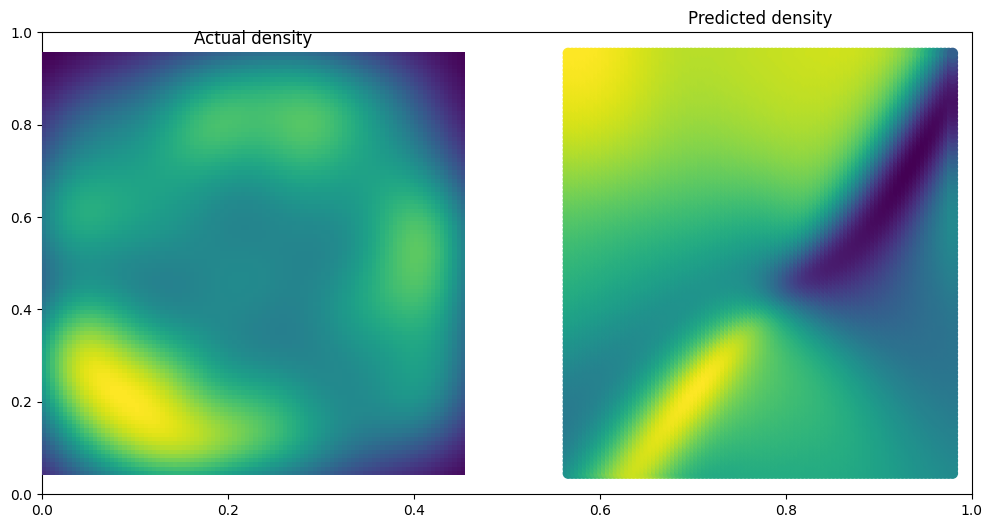

In [20]:
# Compare the actual density and the untrained prediction. They should be very different.
compare_densities2D(rand_frame, model = untrained_model)
plt.show()

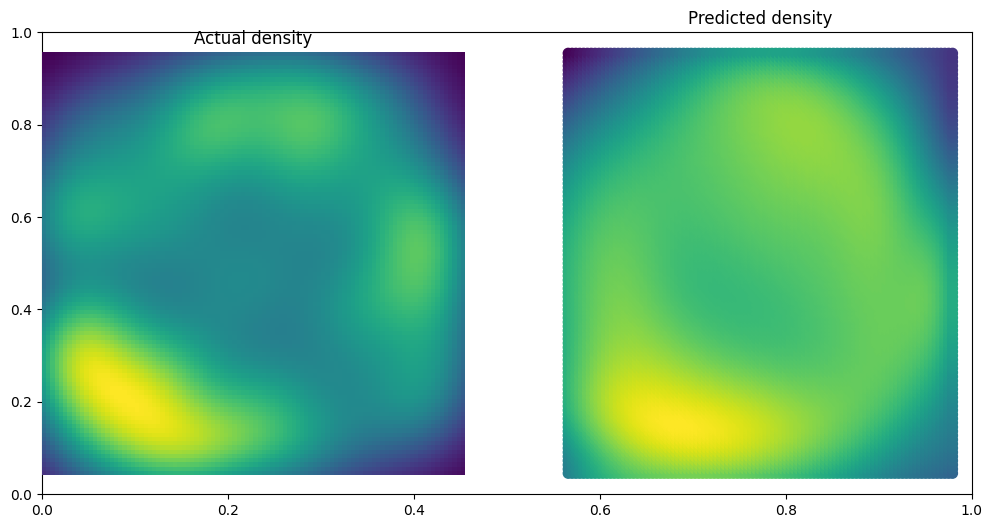

In [21]:
# Use the trained model to predict the density (it should be good)
compare_densities2D(rand_frame, model=trained_model)
plt.show()

In [22]:
# We now want to train the model to learn the lambda parameters

In [23]:
def fun_r1(model, t, x, y, u, v, u_t, u_x, u_y, v_t, v_x, v_y, u_xx, u_xy, u_yy, v_xx, v_xy, v_yy):
    """Residual of the PDE"""
    return -u_t + model.lambd1*u + model.lambd2*(u**2 + v**2)*u + model.lambd3*(u*u_x + v*u_y) + model.lambd4*(u*u_x + u*v_y) \
+ 2*model.lambd5*(u*u_x + v*v_x) + model.lambd6*(u_xx + v_xy) + model.lambd7*(u_xx + u_yy) \
+ model.lambd8*(u*(u_x)**2 + (u**2)*u_xx + 2*u*v*u_xy + u*u_y*v_x + v*u_x*u_y + v*u_y*v_y + (v**2)*u_yy)



def fun_r2(model, t, x, y, u, v, u_t, u_x, u_y, v_t, v_x, v_y, u_xx, u_xy, u_yy, v_xx, v_xy, v_yy):
    """Residual of the PDE"""
    return -u_t + model.lambd1*v + model.lambd2*(u**2 + v**2)*v + model.lambd3*(u*v_x + v*v_y) + model.lambd4*(v*u_x + v*v_y) \
+ 2*model.lambd5*(u*u_y + v*v_y) + model.lambd6*(u_xy + v_yy) + model.lambd7*(v_xx + v_yy) \
+ model.lambd8*(v*(v_y)**2 + (v**2)*v_yy + 2*u*v*v_xy + u*u_x*v_x + u*v_x*v_y + v*u_y*v_x + (u**2)*v_xx)

def fun_cont(model, t, x, y, u, v, u_x, u_y, v_x, v_y, density, density_x, density_y, density_t):
    """Continuity equation """
    return density_t + density_x*u + density*u_x + density_y*v + density*v_y


def get_r1(model, X_data):
    
    with tf.GradientTape(persistent=True) as tape1:
        
        # Unpack data
        t, x, y = X_data[:,0:1], X_data[:,1:2], X_data[:,2:3]
        
        # Watch variables representing t, x, and y during this GradientTape
        tape1.watch(t)
        tape1.watch(x)
        tape1.watch(y)

        # Compute current values u(t,x,y), v(t, x, y)
        u = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 0]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the u component
        v = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 1]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the v component
#        density = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 2]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the density component



        u_x = tape1.gradient(u, x)
        u_y = tape1.gradient(u, y)
        v_x = tape1.gradient(v, x)
        v_y = tape1.gradient(v, y)
#        density_x = tape1.gradient(density, x)
#        density_y = tape1.gradient(density, y)


        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
#        density_t = tape1.gradient(density, t)


    u_xx = tape1.gradient(u_x, x)
    u_xy = tape1.gradient(u_x, y)
    u_yy = tape1.gradient(u_y, y)

    v_xx = tape1.gradient(v_x, x)
    v_xy = tape1.gradient(v_x, y)
    v_yy = tape1.gradient(v_y, y)

    del tape1

    return fun_r1(model, t, x, y, u, v, u_t, u_x, u_y, v_t, v_x, v_y, u_xx, u_xy, u_yy, v_xx, v_xy, v_yy)




def get_r2(model, X_data):
    
    with tf.GradientTape(persistent=True) as tape2:
        
        # Unpack data
        t, x, y = X_data[:,0:1], X_data[:,1:2], X_data[:,2:3]
        
        # Watch variables representing t, x, and y during this GradientTape
        tape2.watch(t)
        tape2.watch(x)
        tape2.watch(y)

        # Compute current values u(t,x,y), v(t, x, y)
        u = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 0]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the u component
        v = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 1]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the v component



        u_x = tape2.gradient(u, x)
        u_y = tape2.gradient(u, y)
        v_x = tape2.gradient(v, x)
        v_y = tape2.gradient(v, y)


        u_t = tape2.gradient(u, t)
        v_t = tape2.gradient(v, t)


    u_xx = tape2.gradient(u_x, x)
    u_xy = tape2.gradient(u_x, y)
    u_yy = tape2.gradient(u_y, y)

    v_xx = tape2.gradient(v_x, x)
    v_xy = tape2.gradient(v_x, y)
    v_yy = tape2.gradient(v_y, y)

    del tape2

    return fun_r2(model, t, x, y, u, v, u_t, u_x, u_y, v_t, v_x, v_y, u_xx, u_xy, u_yy, v_xx, v_xy, v_yy)






def get_cont(model, X_data):
    
    with tf.GradientTape(persistent=True) as tape3:
        
        # Unpack data
        t, x, y = X_data[:,0:1], X_data[:,1:2], X_data[:,2:3]
        
        # Watch variables representing t, x, and y during this GradientTape
        tape3.watch(t)
        tape3.watch(x)
        tape3.watch(y)

        # Compute current values u(t,x,y), v(t, x, y)
        u = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 0]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the u component
        v = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 1]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the v component
        density = model(tf.stack([t[:,0], x[:,0], y[:,0]], axis=1))[:, 2]  # This repacks the (t,x,y) into X, applies the model to X, then extracts the density component


        u_x = tape3.gradient(u, x)
        u_y = tape3.gradient(u, y)
        v_x = tape3.gradient(v, x)
        v_y = tape3.gradient(v, y)
        density_x = tape3.gradient(density, x)
        density_y = tape3.gradient(density, y)

        u_t = tape3.gradient(u, t)
        v_t = tape3.gradient(v, t)
        density_t = tape3.gradient(density, t)


    del tape3

    return fun_cont(model, t, x, y, u, v, u_x, u_y, v_x, v_y, density, density_x, density_y, density_t)

In [24]:
def loss_fn(model, X, U):

    # Compute MSEr, the PDE components of the loss
    r1 = get_r1(model, X)
    r2 = get_r2(model, X)
    cont = get_cont(model, X)
    
#    MSEr = tf.reduce_mean(tf.add(tf.square(r1), tf.square(r2)))
#    MSEr = tf.reduce_mean(tf.add(tf.add(tf.square(r1), tf.square(r2)), tf.square(cont) ))    
    MSEr1 = tf.reduce_mean(tf.square(r1))
    MSEr2 = tf.reduce_mean(tf.square(r2))
    MSEcont = tf.reduce_mean(tf.square(cont))
    # Initialize loss
    loss = MSEr1
    loss += MSEr2
    loss += MSEcont

    # Compute MSEu, the loss associated to the approximation of the functions u, v, and density

        
    uactual = U
    upred = model(X)

#    loss = tf.reduce_mean(tf.square(uactual - upred))
    loss += tf.reduce_mean(tf.square(uactual - upred))

    return loss

In [25]:
def get_grad(model, X, U):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = loss_fn(model, X, U)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [26]:

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-2,1e-3,5e-4])
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-1,1e-2,5e-3])
lr = 0.001
# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)


# Define one training step as a TensorFlow function to increase speed of training

@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_train_data, U_train_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

In [27]:
%%time


# N = 70000 takes about 8 hours with 10000/1000 train/test.

# N = 20000 takes about 17 mins with 1000/100 train/test

reps = 1


lambd_hist = []
loss_hist = []

for j in range(reps):
    
    model = init_model()
    model(np.asarray([[1,1,1], [1,1,1]]))
    # Number of training epochs
    N = 20000
    model.hist = []
    model.lambd_list = []


    for i in range(N+1):

        loss = train_step()

        # Append the current lambda values to the lambda list
        lambd1 = model.lambd1.numpy()
        model.lambd_list.append(lambd1)
        lambd2 = model.lambd2.numpy()
        model.lambd_list.append(lambd2)
        lambd3 = model.lambd3.numpy()
        model.lambd_list.append(lambd3)
        lambd4 = model.lambd4.numpy()
        model.lambd_list.append(lambd4)
        lambd5 = model.lambd5.numpy()
        model.lambd_list.append(lambd5)
        lambd6 = model.lambd6.numpy()
        model.lambd_list.append(lambd6)
        lambd7 = model.lambd7.numpy()
        model.lambd_list.append(lambd7)
        lambd8 = model.lambd8.numpy()
        model.lambd_list.append(lambd8)

        # Append current loss to hist
        model.hist.append(loss.numpy())

        # Output current loss after 50 iterates
        if i%100 == 0:
            print('It {:05d}: loss = {:09f} \n-- λ1 = {:09f} -- λ2 = {:09f} -- λ3 = {:09f} ' 
                      '-- λ4 = {:09f} -- λ5 = {:09f} -- λ6 = {:09f} -- λ7 = {:09f} -- λ8 = {:09f} --'.format(i, loss, lambd1, lambd2, lambd3, lambd4, lambd5, lambd6, lambd7, lambd8))
            
    
    # Store evolution of lambdas
    lambd_hist.append(model.lambd_list)

    # Store evolution of losses
    loss_hist.append(model.hist)

InvalidArgumentError: Graph execution error:

Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 1087457
  }
  dim {
    size: 1087457
  }
}

	 [[{{node ArithmeticOptimizer/AddOpsRewrite_add_18/tmp_var_zeros}}]] [Op:__inference_train_step_508430]